In [1]:
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
from itertools import count

In [2]:
capacity=1000000

batch_size=64
update_iteration=100
tau=0.001
# tau for soft updating

gamma=0.99
directory = './'
hidden1=20
hidden2=64

In [3]:
import numpy as np
import random
import copy

class OU_Noise(object):
    """Ornstein-Uhlenbeck process.
    
    The OU_Noise class has four attributes
    
        size: the size of the noise vector to be generated
        mu: the mean of the noise, set to 0 by default
        theta: the rate of mean reversion, controlling how quickly the noise returns to the mean
        sigma: the volatility of the noise, controlling the magnitude of fluctuations
    """

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.25):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample.
        This method uses the current state of the noise and generates the next sample
        """
        dx = self.theta * (self.mu - self.state) + self.sigma * np.array([np.random.normal() for _ in range(len(self.state))])
        self.state += dx
        return self.state

In [4]:
class Replay_buffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=capacity):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        state: np.array
            batch of state or observations
        action: np.array
            batch of actions executed given a state
        reward: np.array
            rewards received as results of executing action
        next_state: np.array
            next state next state or observations seen after executing action
        done: np.array
            done[i] = 1 if executing ation[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind:
            st, n_st, act, rew, dn = self.storage[i]
            state.append(np.array(st, copy=False))
            next_state.append(np.array(n_st, copy=False))
            action.append(np.array(act, copy=False))
            reward.append(np.array(rew, copy=False))
            done.append(np.array(dn, copy=False))

        return np.array(state), np.array(next_state), np.array(action), np.array(reward).reshape(-1, 1), np.array(done).reshape(-1, 1)


In [5]:
class Actor(nn.Module):
    """
    The Actor model takes in a state observation as input and 
    outputs an action, which is a continuous value.
    
    It consists of four fully coonected linear layers with ReLU activation functions and 
    a final output layer selects one single optimized action for the state
    """
    def __init__(self, n_states, action_dim, hidden1):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, hidden1), 
            nn.ReLU(), 
            nn.Linear(hidden1, 1)
        )
        
    def forward(self, state):
        return self.net(state)

class Critic(nn.Module):
    """
    The Critic model takes in both a state observation and an action as input and 
    outputs a Q-value, which estimates the expected total reward for the current state-action pair. 
    
    It consists of four linear layers with ReLU activation functions, 
    State and action inputs are concatenated before being fed into the first linear layer. 
    
    The output layer has a single output, representing the Q-value
    """
    def __init__(self, n_states, action_dim, hidden2):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_states + action_dim, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, hidden2), 
            nn.ReLU(), 
            nn.Linear(hidden2, action_dim)
        )
        
    def forward(self, state, action):
        return self.net(torch.cat((state, action), 1))

In [6]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [7]:
class DDPG(object):
    def __init__(self, state_dim, action_dim):
        """
        Initializes the DDPG agent. 
        Takes three arguments:
               state_dim which is the dimensionality of the state space, 
               action_dim which is the dimensionality of the action space, and 
               max_action which is the maximum value an action can take. 
        
        Creates a replay buffer, an actor-critic  networks and their corresponding target networks. 
        It also initializes the optimizer for both actor and critic networks alog with 
        counters to track the number of training iterations.
        """
        self.replay_buffer = Replay_buffer()
        
        self.actor = Actor(state_dim, action_dim, hidden1).to(device)
        self.actor_target = Actor(state_dim, action_dim,  hidden1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-3)

        self.critic = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target = Critic(state_dim, action_dim,  hidden2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-2)
        # learning rate

        

        self.num_critic_update_iteration = 0
        self.num_actor_update_iteration = 0
        self.num_training = 0


    def select_action(self, state):
        """
        takes the current state as input and returns an action to take in that state. 
        It uses the actor network to map the state to an action.
        """
        # if isFirstTime:
        #     state = state[0]
        #     isFirstTime = False 

        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def update(self):
        """
        updates the actor and critic networks using a batch of samples from the replay buffer. 
        For each sample in the batch, it computes the target Q value using the target critic network and the target actor network. 
        It then computes the current Q value 
        using the critic network and the action taken by the actor network. 
        
        It computes the critic loss as the mean squared error between the target Q value and the current Q value, and 
        updates the critic network using gradient descent. 
        
        It then computes the actor loss as the negative mean Q value using the critic network and the actor network, and 
        updates the actor network using gradient ascent. 
        
        Finally, it updates the target networks using 
        soft updates, where a small fraction of the actor and critic network weights are transferred to their target counterparts. 
        This process is repeated for a fixed number of iterations.
        """

        for it in range(update_iteration):
            # For each Sample in replay buffer batch
            state, next_state, action, reward, done = self.replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            print(state)
            action = torch.FloatTensor(action).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(1-done).to(device)
            reward = torch.FloatTensor(reward).to(device)

            # Compute the target Q value
            target_Q = self.critic_target(next_state, self.actor_target(next_state))
            target_Q = reward + (done * gamma * target_Q).detach()

            # Get current Q estimate
            current_Q = self.critic(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q, target_Q)
            
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss as the negative mean Q value using the critic network and the actor network
            actor_loss = -self.critic(state, self.actor(state)).mean()
            

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            
            """
            Update the frozen target models using 
            soft updates, where 
            tau,a small fraction of the actor and critic network weights are transferred to their target counterparts. 
            """
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            
           
            self.num_actor_update_iteration += 1
            self.num_critic_update_iteration += 1
    def save(self):
        """
        Saves the state dictionaries of the actor and critic networks to files
        """
        torch.save(self.actor.state_dict(), directory + 'actor.pth')
        torch.save(self.critic.state_dict(), directory + 'critic.pth')
        

    def load(self):
        """
        Loads the state dictionaries of the actor and critic networks to files
        """
        self.actor.load_state_dict(torch.load(directory + 'actor.pth'))
        self.critic.load_state_dict(torch.load(directory + 'critic.pth'))
       


In [19]:
import gym

# create the environment
env_name='MountainCarContinuous-v0'
env = gym.make(env_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define different parameters for training the agent
max_episode=10 # 200
ep_r = 0
total_step = 0
score_hist=[]
# # for rensering the environmnet
# render=True
# render_interval=10
# for reproducibility
# env.seed(0)
torch.manual_seed(-1)
np.random.seed(0)
#Environment action ans states
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
min_Val = torch.tensor(1e-7).float().to(device) 

max_time_steps=50 # 5000
# Exploration Noise
exploration_noise=0.1
exploration_noise=0.1 * max_action

In [20]:
# Create a DDPG instance
agent = DDPG(state_dim, action_dim)
print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

# Train the agent for max_episodes
for i in range(max_episode):
    total_reward = 0
    step =0
    state = env.reset()
    # print(state)
    # state=state[0]
    # print(state)
    for  t in range(max_time_steps):
        action = agent.select_action(state)
        # Add Gaussian noise to actions for exploration
        action = (action + np.random.normal(0, 1, size=action_dim)).clip(-max_action, max_action)
        # print(env.step(action))
        # action += OU_Noise.sample(action)
        next_state = env.step(action)[0]
        reward, done, info = env.step(action)[1:]

        total_reward += reward
        # if render and i >= render_interval : env.render()
        agent.replay_buffer.push((state, next_state, action, reward, float(done)))
        state = next_state
        # print(state)
        if done:
            break
        step += 1
        
    score_hist.append(total_reward)
    total_step += step+1
    print("Episode: \t{}  Total Reward: \t{:0.2f}".format( i, total_reward))
    agent.update()
    if i % 100 == 0:
        agent.save()
env.close()

State dim: 2, Action dim: 1
Episode: 	0  Total Reward: 	-2.86
tensor([[-4.0130e-01, -1.2786e-02],
        [-3.2803e-01,  3.4444e-03],
        [-3.4609e-01,  5.7201e-03],
        [-3.4838e-01, -1.0675e-02],
        [-4.9952e-01,  4.5959e-03],
        [-4.8969e-01,  4.0540e-03],
        [-4.6901e-01,  1.1018e-02],
        [-5.9358e-01,  1.0412e-02],
        [-6.6217e-01, -4.2937e-03],
        [-5.2445e-01,  0.0000e+00],
        [-6.2670e-01, -7.5911e-03],
        [-4.6901e-01,  1.1018e-02],
        [-6.1039e-01, -1.0861e-02],
        [-5.2445e-01,  0.0000e+00],
        [-4.8969e-01,  4.0540e-03],
        [-6.6796e-01, -2.1702e-03],
        [-6.5294e-01, -4.3816e-03],
        [-4.9952e-01,  4.5959e-03],
        [-5.8661e-01, -1.4895e-02],
        [-5.0575e-01,  5.9187e-03],
        [-6.5294e-01, -4.3816e-03],
        [-5.7553e-01,  8.4991e-03],
        [-3.4609e-01,  5.7201e-03],
        [-4.9952e-01,  4.5959e-03],
        [-6.3628e-01,  9.8687e-03],
        [-3.4838e-01, -1.0675e-02],
  

In [21]:
import matplotlib.pyplot as plt 
import numpy as np
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    #plt.savefig(figure_file)

Exception ignored in: <function Viewer.__del__ at 0x0000027AF6F8A430>
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\classic_control\rendering.py", line 143, in __del__
    self.close()
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\classic_control\rendering.py", line 62, in close
    self.window.close()
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\window\__init__.py", line 661, in close
    app.windows.remove(self)
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\_weakrefset.py", line 110, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x0000027AF6F883B0; to 'Win32Window' at 0x0000027AFF691D60>


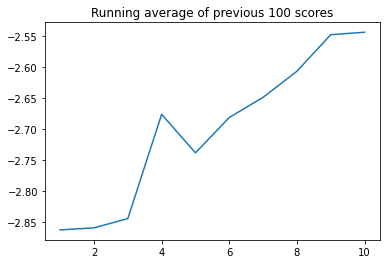

In [22]:
x = [i+1 for i in range(len(score_hist))]
plot_learning_curve(x, score_hist)

In [24]:
test_iteration=100
max_length_of_trajectory=1000    
for i in range(test_iteration):
    state = env.reset()
    for t in count():
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(np.float32(action))
        ep_r += reward
        print(reward)
        
        # env.render()
        if done: 
            # print("reward{}".format(reward))
            print("Episode \t{}, the episode reward is \t{:0.2f}".format(i, ep_r))
            ep_r = 0
            env.render()
            break
        state = next_state
env.close()   

-0.0007491491440192511
-0.0007511139402151257
-0.0007530832492680163
-0.0007550421884139846
-0.0007569765756781311
-0.000758872157896745
-0.0007607151337716057
-0.0007624913807016631
-0.0007641877615068238
-0.0007657909632251326
-0.0007672890702539681
-0.0007686702730072882
-0.0007699235307230768
-0.0007710392378069087
-0.0007720083212184259
-0.0007728230364566713
-0.00077347671684041
-0.0007739641760978523
-0.0007742813233070633
-0.000774425299946474
-0.0007743954020568433
-0.0007741912463700374
-0.0007738148680148049
-0.000773269144361205
-0.0007725584459032042
-0.0007716884982983175
-0.0007706662427836797
-0.0007694999568391092
-0.0007681985891601573
-0.0007667727931937097
-0.0007652333470010098
-0.0007635923163740233
-0.0007618622595831293
-0.0007600566065566251
-0.0007581888679908388
-0.0007562735355064521
-0.0007543246463215247
-0.0007523568157587202
-0.0007503847140151676
-0.0007484231928625074
-0.0007464863828053281
-0.000744588727351303
-0.0007427443412823254
-0.00074096675993

NameError: name 'glPushMatrix' is not defined